In [9]:
# Celda 1 (Actualizada): Importaciones y carga de datos completo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import unicodedata
import plotly.express as px
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Configuración de estilo para los gráficos
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 8)

# Cargar el dataset COMPLETO para el modelado
df_modelo = pd.read_csv('../data/processed/dataset_modelo_energias_renovables.csv')

# Cargar el shapefile (el código de carga es el mismo)
try:
    gdf_provincias = gpd.read_file('../data/geographic/ne_10m_admin_1_states_provinces.shp')
    gdf_ecuador = gdf_provincias[gdf_provincias['admin'] == 'Ecuador'].copy()
    gdf_ecuador['name_std'] = gdf_ecuador['name'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', errors='ignore').decode('utf-8'))
    df_modelo['provincia_std'] = df_modelo['provincia'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', errors='ignore').decode('utf-8'))
    print("Shapefile de Ecuador y dataset completo cargados y procesados.")
except Exception as e:
    print(f"No se pudo cargar el shapefile. Error: {e}")

display(df_modelo.head())

Shapefile de Ecuador y dataset completo cargados y procesados.


,provincia,año,altitud,temp_promedio_anual_C,viento_promedio_anual_ms,potencial_hidrico_proxy_mm,potencia_solar_media_anual_kw,energia_solar_anual_kwh,viabilidad_solar,potencia_eolica_media_anual_w,energia_eolica_anual_kwh,viabilidad_eolica,viabilidad_hidrica,provincia_std
0,Azuay,2019,2560,13.130822,3.323616,1077.24,1.979583,17341.146,Bajo,68434.334780,599484.772674,Alto,Medio,Azuay
1,Azuay,2020,2560,13.589317,3.194399,860.99,2.068855,18172.824,Alto,59889.909196,526072.962378,Alto,Bajo,Azuay
2,Azuay,2021,2560,13.016658,3.100274,1160.65,1.991193,17442.852,Bajo,54874.723459,480702.577504,Alto,Medio,Azuay
3,Azuay,2022,2560,13.055562,3.035233,952.06,1.925845,16870.398,Bajo,52153.404235,456863.821097,Medio,Bajo,Azuay
4,Azuay,2023,2560,13.499918,3.028822,1072.91,1.998297,17505.078,Bajo,51012.715932,446871.391565,Medio,Medio,Azuay


In [14]:
# Celda 2 (Solución Pragmática): Volver al código que funcionaba y silenciar la advertencia

import warnings
# Ignorar la advertencia de deprecación de Plotly para esta celda
warnings.filterwarnings("ignore", category=DeprecationWarning)

def generar_mapa_energia(tipo_energia, df, gdf):
    """
    Genera y muestra un mapa coroplético usando la función original y funcional.
    """
    # --- Lógica para preparar los datos según la selección ---
    if tipo_energia == 'Solar':
        valor_col = 'energia_solar_anual_kwh'
        titulo_mapa = 'Potencial de Energía Solar Anual (kWh)'
        color_scale = "YlOrRd"
    elif tipo_energia == 'Eólica':
        valor_col = 'energia_eolica_anual_kwh'
        titulo_mapa = 'Potencial de Energía Eólica Anual (kWh)'
        color_scale = "Viridis"
    elif tipo_energia == 'Hídrica':
        valor_col = 'potencial_hidrico_proxy_mm'
        titulo_mapa = 'Potencial Hídrico Anual (Proxy mm de precipitación)'
        color_scale = "Blues"
    else:
        print("Tipo de energía no reconocido. Elige 'Solar', 'Eólica' o 'Hídrica'.")
        return

    # Calcular el promedio por provincia para el tipo de energía seleccionado
    energia_promedio = df.groupby('provincia_std')[valor_col].mean().reset_index()
    
    # Unir con el GeoDataFrame
    mapa_datos = gdf.merge(energia_promedio, left_on='name_std', right_on='provincia_std', how='left')

    # --- VOLVEMOS A LA FUNCIÓN ORIGINAL QUE SABÍAMOS QUE FUNCIONABA ---
    fig_mapa = px.choropleth_mapbox(
        mapa_datos,
        geojson=mapa_datos.geometry,
        locations=mapa_datos.index,
        color=valor_col,
        hover_name='name',
        hover_data={valor_col: ':.2f'},
        color_continuous_scale=color_scale,
        mapbox_style="carto-positron", 
        zoom=5.5,
        center={"lat": -1.831, "lon": -78.183},
        opacity=0.7,
        title=titulo_mapa
    )
    fig_mapa.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig_mapa.show()


# --- Generar y mostrar los tres mapas ---
if 'gdf_ecuador' in locals():
    print("--- Generando Mapa de Energía Solar ---")
    generar_mapa_energia('Solar', df_modelo, gdf_ecuador)
    
    print("\n--- Generando Mapa de Energía Eólica ---")
    generar_mapa_energia('Eólica', df_modelo, gdf_ecuador)
    
    print("\n--- Generando Mapa de Energía Hídrica ---")
    generar_mapa_energia('Hídrica', df_modelo, gdf_ecuador)

else:
    print("No se pueden generar los mapas porque el shapefile no se cargó correctamente.")

--- Generando Mapa de Energía Solar ---



--- Generando Mapa de Energía Eólica ---



--- Generando Mapa de Energía Hídrica ---


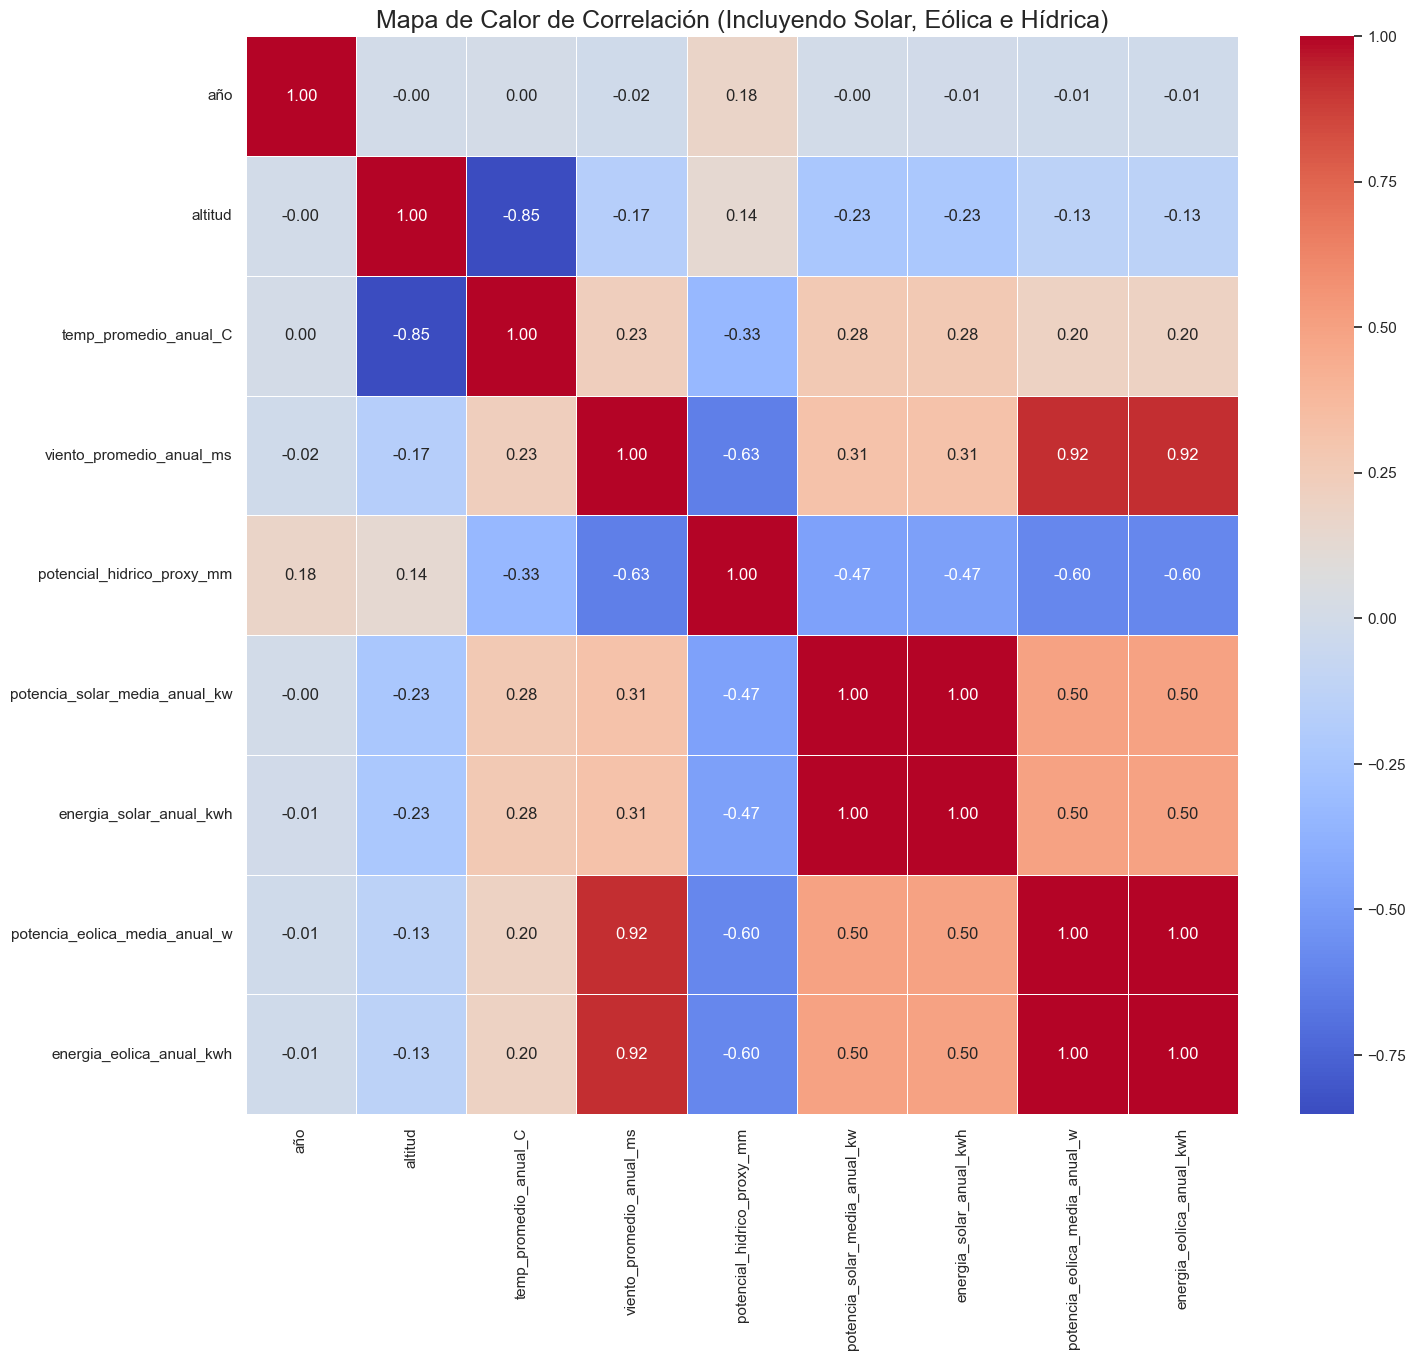

In [15]:
# Celda 3 (Actualizada): Mapa de Calor de Correlación con todas las variables

# Seleccionar solo las columnas numéricas del nuevo dataset
df_numerico = df_modelo.select_dtypes(include=np.number)

# Calcular la matriz de correlación
corr_matrix = df_numerico.corr()

# Crear el mapa de calor
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, 
            annot=True,      
            fmt=".2f",       
            cmap='coolwarm', 
            linewidths=.5)
plt.title('Mapa de Calor de Correlación (Incluyendo Solar, Eólica e Hídrica)', fontsize=18)
plt.show()

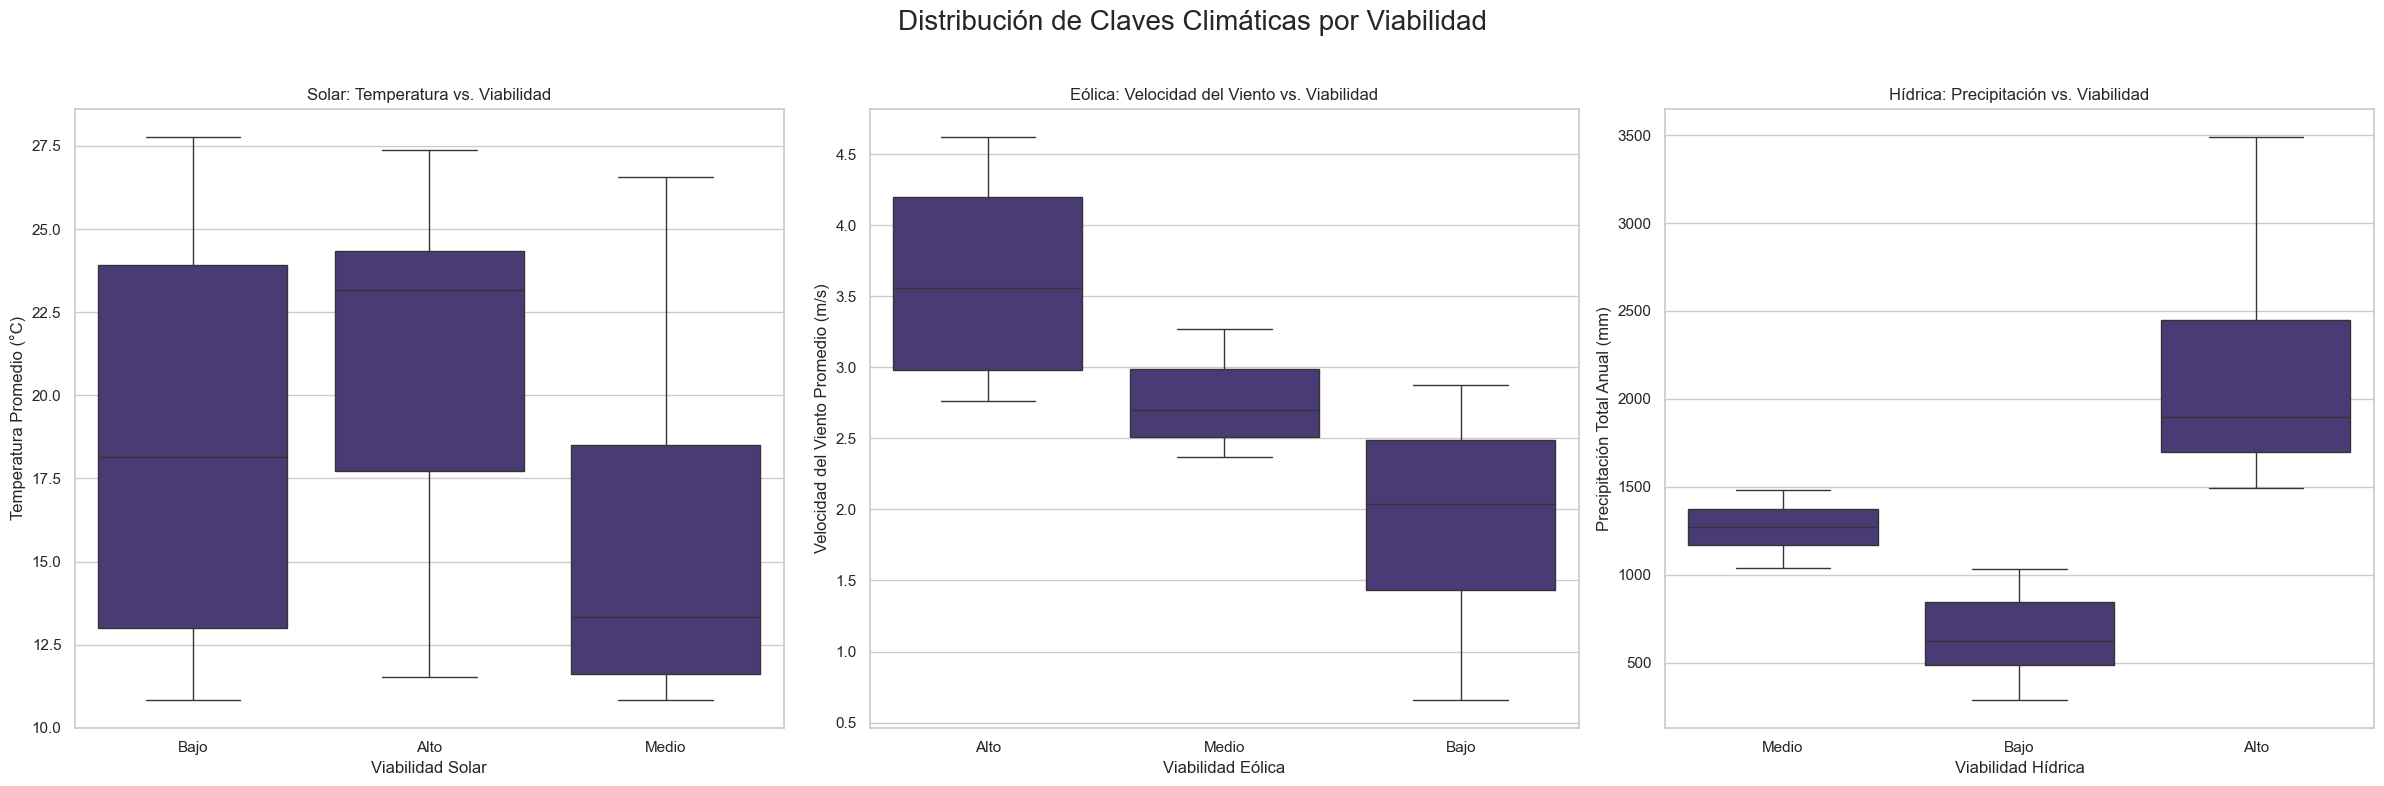

In [4]:
# Celda 4 (Nueva): Análisis de Viabilidad por Tipo de Energía

# Crear una figura con 3 subplots, uno para cada energía
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Distribución de Claves Climáticas por Viabilidad', fontsize=20)

# --- Gráfico para Energía Solar ---
sns.boxplot(ax=axes[0], x=df_modelo['viabilidad_solar'], y=df_modelo['temp_promedio_anual_C'])
axes[0].set_title('Solar: Temperatura vs. Viabilidad')
axes[0].set_xlabel('Viabilidad Solar')
axes[0].set_ylabel('Temperatura Promedio (°C)')

# --- Gráfico para Energía Eólica ---
sns.boxplot(ax=axes[1], x=df_modelo['viabilidad_eolica'], y=df_modelo['viento_promedio_anual_ms'])
axes[1].set_title('Eólica: Velocidad del Viento vs. Viabilidad')
axes[1].set_xlabel('Viabilidad Eólica')
axes[1].set_ylabel('Velocidad del Viento Promedio (m/s)')

# --- Gráfico para Energía Hídrica ---
sns.boxplot(ax=axes[2], x=df_modelo['viabilidad_hidrica'], y=df_modelo['potencial_hidrico_proxy_mm'])
axes[2].set_title('Hídrica: Precipitación vs. Viabilidad')
axes[2].set_xlabel('Viabilidad Hídrica')
axes[2].set_ylabel('Precipitación Total Anual (mm)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [5]:
# Celda 5 (Nueva): Funciones auxiliares para visualizar resultados de modelos

def plot_predicciones_vs_real(y_test, y_pred, titulo):
    """Genera un gráfico de dispersión de Predicho vs. Real."""
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valor Real', fontsize=12)
    plt.ylabel('Valor Predicho', fontsize=12)
    plt.title(titulo, fontsize=16)
    plt.grid(True)
    plt.show()

def plot_importancia_variables(modelo, features_names, titulo):
    """Genera un gráfico de barras con la importancia de las variables."""
    # Obtener el modelo entrenado del pipeline
    modelo_rf = modelo.named_steps['regressor']
    
    # Obtener los nombres de las features después del OneHotEncoder
    ohe_feature_names = modelo.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['provincia'])
    all_feature_names = ['altitud', 'temp_promedio_anual_C', 'viento_promedio_anual_ms', 'potencial_hidrico_proxy_mm'] + list(ohe_feature_names)

    # Obtener la importancia y crear un DataFrame
    importances = pd.Series(modelo_rf.feature_importances_, index=all_feature_names)
    importances = importances.sort_values(ascending=False).head(10)

    # Graficar
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importances.values, y=importances.index, palette='viridis')
    plt.title(titulo, fontsize=16)
    plt.xlabel('Importancia', fontsize=12)
    plt.ylabel('Variable', fontsize=12)
    plt.show()

print("Funciones de visualización de modelos definidas.")

Funciones de visualización de modelos definidas.


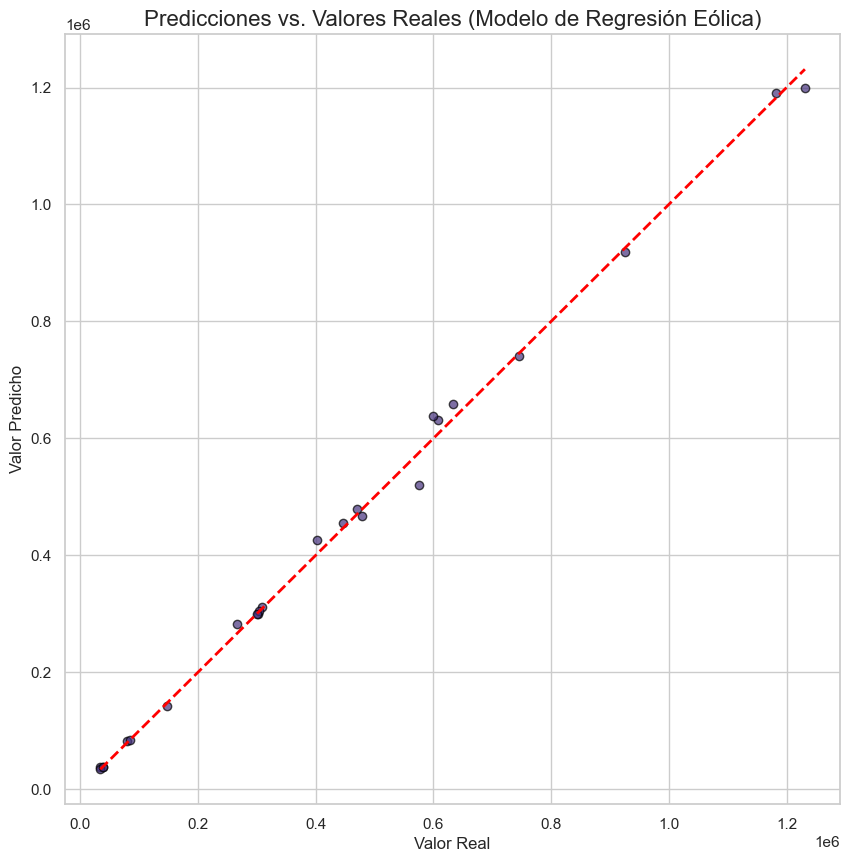

/var/folders/mh/p902nyz14477qbgspbxj31lw0000gn/T/ipykernel_23564/3331076268.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




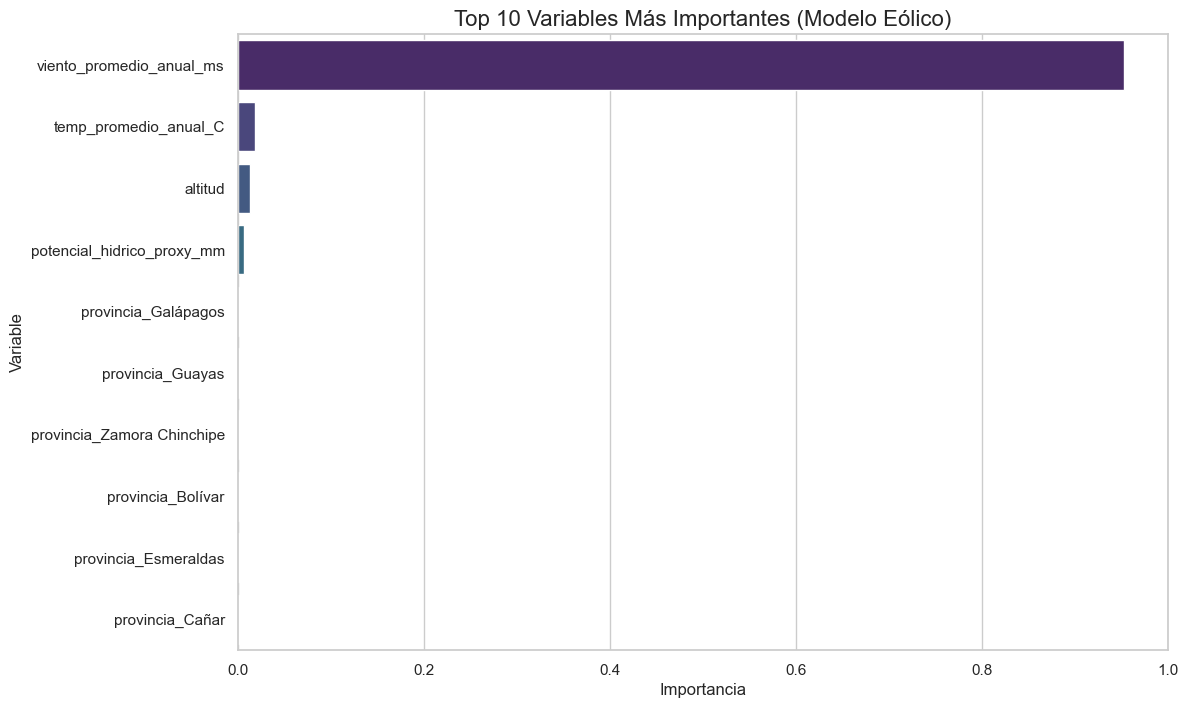

In [6]:
# Celda 6: Visualización de Resultados del Modelo Eólico

# Cargar el modelo y preparar los datos (igual que en el notebook de modelado)
modelo_eolico = joblib.load('../deployment/modelo_regresion_eolica.pkl')
features = ['provincia', 'altitud', 'temp_promedio_anual_C', 'viento_promedio_anual_ms', 'potencial_hidrico_proxy_mm']
X = df_modelo[features]
y = df_modelo['energia_eolica_anual_kwh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generar predicciones
y_pred = modelo_eolico.predict(X_test)

# Usar las funciones para graficar
plot_predicciones_vs_real(y_test, y_pred, 'Predicciones vs. Valores Reales (Modelo de Regresión Eólica)')
plot_importancia_variables(modelo_eolico, features, 'Top 10 Variables Más Importantes (Modelo Eólico)')

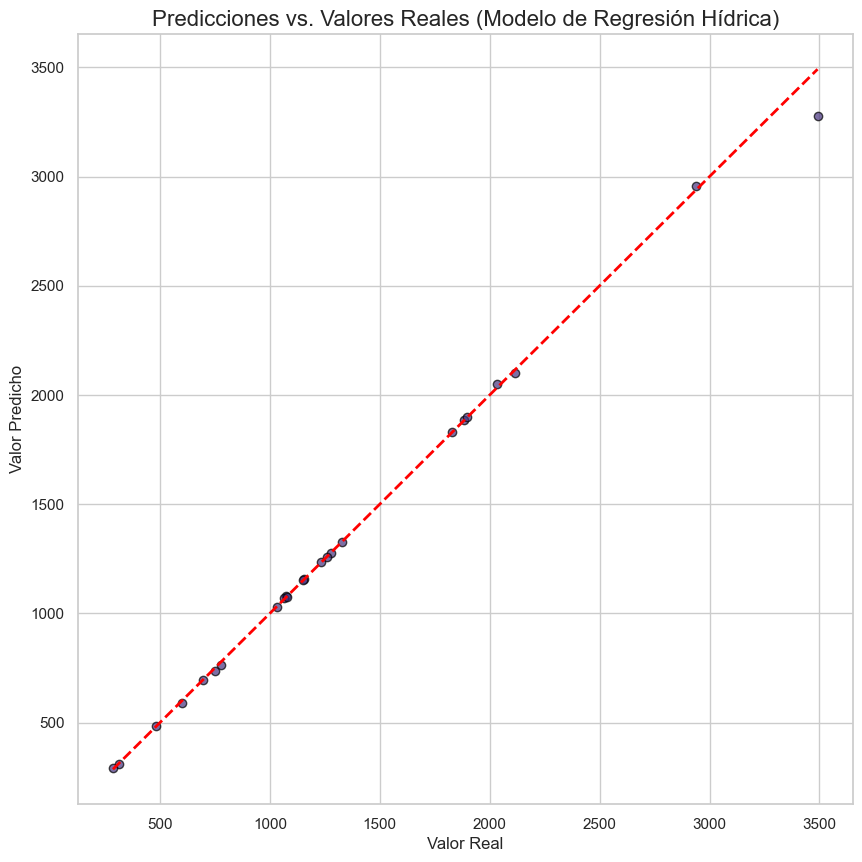

/var/folders/mh/p902nyz14477qbgspbxj31lw0000gn/T/ipykernel_23564/3331076268.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




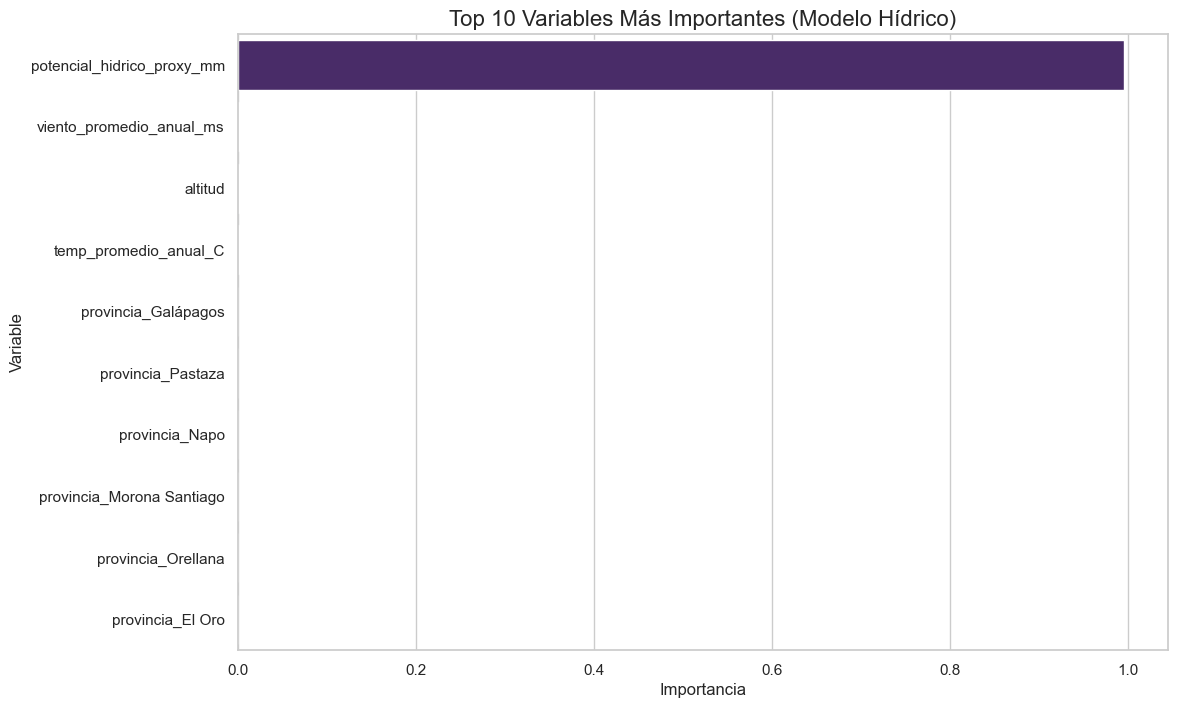

In [7]:
# Celda 7: Visualización de Resultados del Modelo Hídrico

# Cargar el modelo y preparar los datos
modelo_hidrico = joblib.load('../deployment/modelo_regresion_hidrica.pkl')
y = df_modelo['potencial_hidrico_proxy_mm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generar predicciones
y_pred = modelo_hidrico.predict(X_test)

# Usar las funciones para graficar
plot_predicciones_vs_real(y_test, y_pred, 'Predicciones vs. Valores Reales (Modelo de Regresión Hídrica)')
plot_importancia_variables(modelo_hidrico, features, 'Top 10 Variables Más Importantes (Modelo Hídrico)')